#Проектная работа по итогу курса "Интеллектуальный анализ данных в бизнесе"

Авторы: Кобылин Константин, Курочкин Даниил

Группа: 11-006

##Описание работы

В датасете хранятся данные о пассажирах из следующей смоделированной ситуации: в далёком будущем ситуация с Титаником повторяется, но в этот раз в космосе. Нам, как исследователям, предстоит выяснить, кому из пассажиров удалось выжить, полагаясь на данные из датасета. И сделать мы это собираемся 5-ю разными методами, чтобы выяснить, какой из них проявит себя в этой задаче наиболее эффективно.

##Импорты и загрузка датасета

In [ ]:
!pip install git+https://github.com/ML-Challenge/learntools.git
import os
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex3 import *
print("Setup Complete")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ML-Challenge/learntools.git to /tmp/pip-req-build-jclzo4u4
  Running command git clone -q https://github.com/ML-Challenge/learntools.git /tmp/pip-req-build-jclzo4u4


Setup Complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Read the data
X_train = pd.read_csv('/content/drive/MyDrive/Data Analysis/Project/train.csv', index_col='PassengerId')
X_test = pd.read_csv('/content/drive/MyDrive/Data Analysis/Project/test.csv', index_col='PassengerId')

X_train.drop(['Name'], axis=1, inplace=True)
X_test.drop(['Name'], axis=1, inplace=True)

X_train.dropna(axis=0, subset=['Transported'], inplace=True)
y = X_train.Transported            
X_train.drop(['Transported'], axis=1, inplace=True)
X_train_EDA = X_train

X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


## EDA и подготовка данных

Перед построением моделей изучим набор данных, чтобы получить представление об их составе.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
dtypes: float64(6), object(5)
memory usage: 815.0+ KB


Заметим, что датасет содержит почти 8700 строк и 10 столбцов. 

Рассмотрим их подробнее:


1. HomePlanet - планета, с которой отправился пассажир
2. CryoSleep - согласился ли пассажир провести путешествие в крио-сне, тем самым оставшись в своей комнате на протяжение всего путешествия
3. Cabin - номер комнаты пассажира
4. Destination - планета, куда отправился пассажир
5. Age - возраст пассажира
6. VIP - оплатил ли пассажир VIP сервис
7. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - эти столбцы отражают, сколько пассажир потратил денег на указанные услуги

Также изначально датасет содержат столбец с именем, но в ходе исследования оно нам никак не понадобится и будет только добавлять шум, поэтому было принято решение убрать эту фичу.



##Категориальные значения

In [ ]:
X_train.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
dtype: object

Здесь мы убеждаемся, что в датасете присутствуют категориальные значения, и их необходимо обработать.

Для этого прибегнем к помощи метода get_dummies, который превращает категориальные переменные в фиктивные, представленные числовыми значениями.

In [ ]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols = categorical_features + num_features


X_train = pd.get_dummies(X_train[cols])
X_test = pd.get_dummies(X_test[cols])
X_test

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
PassengerId,,,,,,,,,,,,,,,,
0013_01,27.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0
0018_01,19.0,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1,1,0
0019_01,31.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0
0021_01,38.0,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1,1,0
0023_01,20.0,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,34.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0
9269_01,42.0,0.0,847.0,17.0,10.0,144.0,1,0,0,1,0,0,0,1,1,0
9271_01,NaN,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,0,0,1,0


Видим, что столбцы с категориальными значениями разделились на 2-3 столбца. Всего получилось 16 столбцов, что является относительно оптимальным числом для использования XGBoost, поэтому использование метода get_dummies() было оправданным.

##Пропущенные значения

In [ ]:
cols_with_missing = [(col, X_train[col].isnull().sum() * 100 // len(X_train)) for col in X_train.columns
                     if X_train[col].isnull().any()]
cols_with_missing.sort(key=lambda x: x[1], reverse=True)
cols_with_missing

[('Age', 2),
 ('RoomService', 2),
 ('FoodCourt', 2),
 ('ShoppingMall', 2),
 ('Spa', 2),
 ('VRDeck', 2)]

На основе данного output'a программы можно прийти к выводу, что в каждом из значений отсутствует примерно 2% значений, что не так критично, и нет никакой нужды полностью избавляться от столбца.

Вместо этого мы заполним пустые значения с помощью SimpleImputer, воспользовавшись стратегией заполнения пустых значений медианным значением столбца.

In [ ]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy = 'median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns
imputed_X_test

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,27.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,19.0,0.0,9.0,0.0,2823.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,38.0,0.0,6652.0,0.0,181.0,585.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,20.0,10.0,0.0,635.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4273,42.0,0.0,847.0,17.0,10.0,144.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4274,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4275,27.0,0.0,2680.0,0.0,0.0,523.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Проверим, остались ли ещё пустые значения.

In [ ]:
imputed_X_test.isnull().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
dtype: int64

Таким образом, мы убедились, что SimpleImputer помог нам решить вопрос с NaN значениями.

Посмотрим на распределения и зависимости целевого столбца.

Импорт библиотек для визуализации данных:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import plotly.express as px
import time

Text(0.5, 1.0, 'Target distribution')

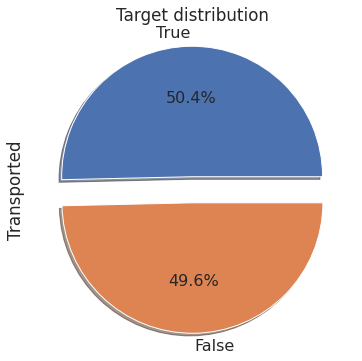

In [ ]:
plt.figure(figsize=(6,6))
y.value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True,
                                                       textprops={'fontsize':16}).set_title("Target distribution")

Целевой столбец сбалансирован, поэтому нам нам не нужно прибегать к овер- и андер-семплингу.

Text(0.5, 0, 'Age (years)')

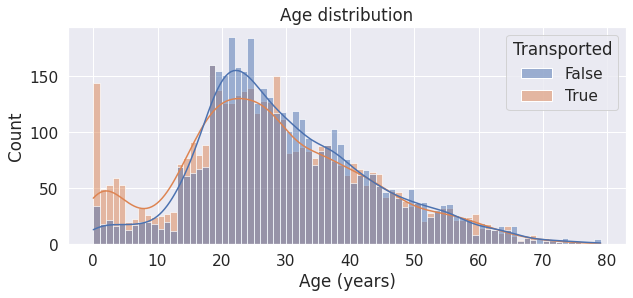

In [ ]:
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=X_train_EDA, x='Age', hue=y, binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')


*   Дети в возрасте до 18 лет чаще переносились, чем нет 
*   18-25-летние чаще оставались в этом измерении
*   У лиц старше 25 лет вероятность остаться и перенестись примерно равны

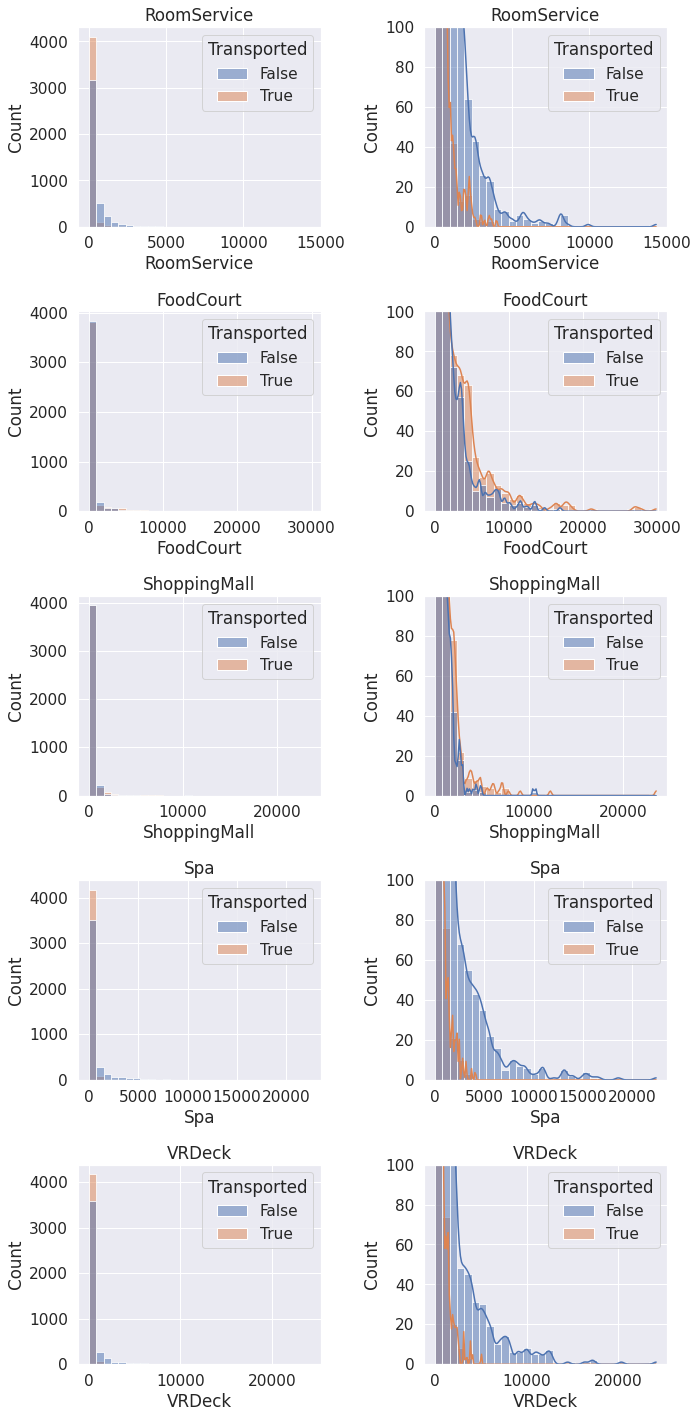

In [ ]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=X_train, x=var_name, axes=ax, bins=30, kde=False, hue=y)
    ax.set_title(var_name)
    
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=X_train, x=var_name, axes=ax, bins=30, kde=True, hue=y)
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Данные графики показывают распределение потраченных пассажирами денег на разные услуги.

* Большинство людей не тратят никаких денег (как мы можем видеть слева), это связано с тем, что они выбрали криосон, корреляция абсолютная.
* Распределение расходов уменьшается экспоненциально (как мы можем видеть справа).
* Существует небольшое количество выбросов.
* Люди, которых перевозили, как правило, тратили меньше.
* Распределение обслуживания номеров, спа-центра и VRDeck отличаются от фуд-корта и торгового центра - мы можем рассматривать это как роскошь по сравнению с основными удобствами.


Посмотрим на зависимость от планеты отправления:

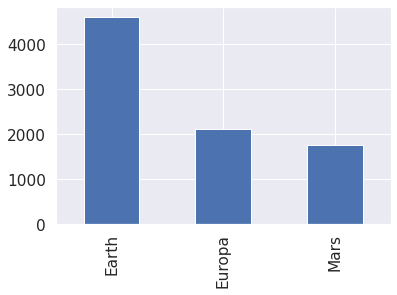

In [ ]:
X_train_EDA['HomePlanet'].value_counts().plot(kind='bar')

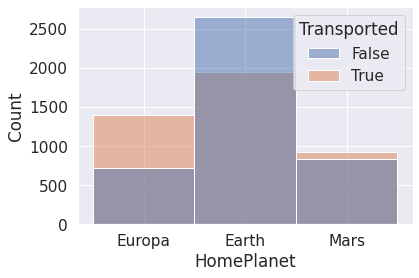

In [ ]:
sns.histplot(X_train_EDA, x='HomePlanet', hue=y)

*  Мы можем видеть, что большинство перенесенных было с Земли
* Земляне имели большую вероятность быть перенесенными в другое измерение.


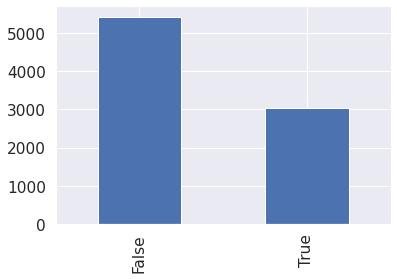

In [ ]:
X_train_EDA['CryoSleep'].value_counts().plot(kind='bar')

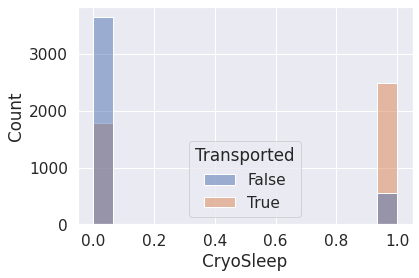

In [ ]:
sns.histplot(X_train_EDA, x=X_train_EDA['CryoSleep'].dropna().astype('int'), hue=y)



*   Большинство людей не находились в криосне
* У тех, кто находился в криосне, было гораздо больше шансов не подвергнуться перемещению



##Модели

### Выбор моделей:


1.   **Логистическая регрессия**. В отличие от линейной регрессии, которая использует наименьшие квадраты, эта модель использует оценку максимального правдоподобия для соответствия сигмоидной кривой распределению целевой переменной. 

2.  **KNN**. Работает путем выбора мажоритарного класса k-ближайших соседей, где обычно используется метрика евклидова расстояния. Это простой и эффективный алгоритм, но он может быть чувствителен ко многим факторам, например, к значению k, предварительной обработке данных и используемой метрике.

3. **Random Forest** (Случайный лес). Ансамбль деревьев решений, который может быть использован для данной классификации. Здесь отдельные деревья строятся с помощью пакетирования (т.е. агрегирования загрузочных элементов, которые представляют собой не что иное, как множество наборов данных train, созданных с помощью выборки с заменой) и разделяются с использованием меньшего количества функций. Полученный в результате разнообразный лес некоррелированных деревьев демонстрирует меньшую дисперсию, а следовательно, он более устойчив к изменениям в данных и повышает точность прогнозирования новых данных.

4. **XGBoost**. Похож на RF в том, что он состоит из ансамбля деревьев решений. Разница заключается в том, как эти деревья выводятся: XGBoost использует экстремальное повышение градиента при оптимизации своей целевой функции. Он часто дает наилучшие результаты, но работает относительно медленно по сравнению с другими алгоритмами повышения градиента.

5. **CatBoost**. Категориальный бустинг - это алгоритм с открытым исходным кодом, основанный на деревьях решений с градиентным усилением. Он поддерживает числовые, категориальные и текстовые функции. Он хорошо работает с разнородными данными и даже с относительно небольшими данными. По задумке совмещает в себе лучшие идеи XGBoost и LightGBoost.


Разделим данные на тренировочные и валидационные:

In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(imputed_X_train ,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

#LogisticRegression, KNN и RandomForest

Создадим Classifier'ы алгоритмов логиcтической регрессии, KNN и RandomForest, воспользовавшись библиотекой sklearn. 

Также подготовим сетки для GreedSearch - алгоритма автоматического подбора оптимальных параметров для модели.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0)
}

LR_grid = {'penalty': ['l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid
}

Обучаем модели с помощью GridSearch (но без перекрестной валидации, чтобы это не занимало слишком много времени), чтобы получить приблизительное представление о том, какие модели являются лучшими для этого набора данных.

In [ ]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)


    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)


    clf_best_params[key]=clf.best_params_
    

    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Модель:', key)
    print('Время обучения:', valid_scores.iloc[i,2])
    print('')
    i+=1

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Модель: LogisticRegression
Время обучения: 0.13

Модель: KNN
Время обучения: 0.15

Модель: RandomForest
Время обучения: 1.78



Теперь посмотрим результаты обучения моделей:

In [ ]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.782059,0.13
1,KNN,0.769983,0.15
2,RandomForest,0.787234,1.78


Как мы можем видеть, RandomForest показал лучший результат **0.787**.
Поэтому нам стоит перейти к XGBoost, так как это должно улучшить наш результат.

#4. XGBoost

Для нашей задачи необходим модуль XGBClassifier. Создадим с его помощью модель, заполним её тренировочными данными и начнём её обучение. Далее попробуем нашу обучившуюся модель на тестовых данных, чтобы она сделала предсказание.

In [ ]:
from xgboost import XGBClassifier

my_model = XGBClassifier()
my_model.fit(imputed_X_train, y)

predictions = my_model.predict(imputed_X_test)
predictions

array([ True, False,  True, ...,  True,  True,  True])

##Предсказание

Теперь на основе полученного предсказания составим новую таблицу, которую в дальнейшем отправим на соревнование. Она будет состоять из столбца с Id пассажира и информацией, выжил ли он.

In [ ]:
prediction = my_model.predict(X_test)
result = pd.DataFrame({
    "PassengerId": X_test.index,
    "Transported": prediction
})
result['PassengerId'] = result['PassengerId'].astype('str')
result

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


##Экспорт в csv

После этого экспортируем полученный результат в csv таблицу для дальнейшей отправки.

In [ ]:
result.to_csv("/content/drive/MyDrive/Data Analysis/Project/result.csv", index=False)

##Результат

С помощью XGBoost удалось достичь точности предсказания в 79,82% !

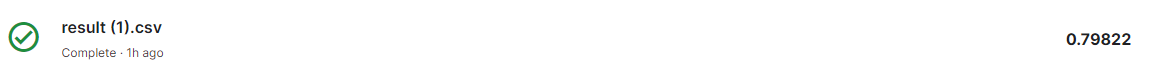

#CatBoost

##Импорты и загрузка датасета

In [ ]:
# Set up code checking
!pip install git+https://github.com/ML-Challenge/learntools.git
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
import os
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex3 import *
print("Setup Complete")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


X_train = pd.read_csv('/content/drive/MyDrive/Data Analysis/Project/train.csv', index_col='PassengerId')
X_test = pd.read_csv('/content/drive/MyDrive/Data Analysis/Project/test.csv', index_col='PassengerId')

X_train.drop(['Name'], axis=1, inplace=True)
X_test.drop(['Name'], axis=1, inplace=True)

X_train.dropna(axis=0, subset=['Transported'], inplace=True)
y = X_train.Transported              
X_train.drop(['Transported'], axis=1, inplace=True)

Данный датасет уже был описан, поэтому сосредоточимся на особенностях использования CatBoost.

##Категориальные данные

In [ ]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_features_indices

array([0, 1, 2, 3, 5])

Здесь мы получили индексы категориальных фич, которые понадобятся нам в дальнейшем при создании модели.

##Пропущенные значения

In [ ]:
# Fill in the line below: get names of columns with missing values
cols_with_missing = [(col, X_train[col].isnull().sum() * 100 // len(X_train)) for col in X_train.columns
                     if X_train[col].isnull().any()]
cols_with_missing.sort(key=lambda x: x[1], reverse=True)
cols_with_missing

[('HomePlanet', 2),
 ('CryoSleep', 2),
 ('Cabin', 2),
 ('Destination', 2),
 ('Age', 2),
 ('VIP', 2),
 ('RoomService', 2),
 ('FoodCourt', 2),
 ('ShoppingMall', 2),
 ('Spa', 2),
 ('VRDeck', 2)]

Датасет по-прежнему тот же самый, поэтому снова убеждаемся, что пропущенных значений не более 2%

In [ ]:
X_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0


##Заполнение пустых значений

Воспользуемся SimpleImputer'ом, но в этот раз выберем немного другую стратегию. Как так данные категориальные, стратегии "mean" (то есть среднее) или "median" (то есть медианное) нам не подходят, поэтому воспользуемся стратегией "most_frequent" (то есть самое часто встречающееся в столбце значение)

In [ ]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy = 'most_frequent')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns
imputed_X_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0


##Преобразование типов данных

In [ ]:
for col in imputed_X_train:
    if type(imputed_X_train[col]) == "float64":
        imputed_X_train[col] = imputed_X_train[col].astype(int)

Используя CatBoost, нужно обратить внимание на то, что из числовых значений этот модуль может обрабатывать только тип int, поэтому в каждом столбце нашего датасета меняем тип данных с float на int.

In [ ]:
imputed_X_train.dtypes

HomePlanet      object
CryoSleep       object
Cabin           object
Destination     object
Age             object
VIP             object
RoomService     object
FoodCourt       object
ShoppingMall    object
Spa             object
VRDeck          object
dtype: object

Видим, что столбцов с типом данных int уже не осталось, значит, можно предпринимать дальнейшие шаги.

##Модель

С помощью CatBoost создадим модель, настроив её через количество итераций и коэффициент скорости обучения. Затем заполним модель тестовыми данными и укажем категориальные фичи. После этого сделаем предсказание с помощью построенной модели.

In [ ]:
from catboost import CatBoostClassifier

my_model = CatBoostClassifier(
    iterations = 1000,
    learning_rate=0.03,
    logging_level='Silent'
)

my_model.fit(imputed_X_train, y,
             cat_features=categorical_features_indices,
             logging_level='Verbose',
             plot=True)


predictions = my_model.predict(imputed_X_test)
predictions

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6803661	total: 19.7ms	remaining: 19.7s
1:	learn: 0.6687482	total: 34.7ms	remaining: 17.3s
2:	learn: 0.6549936	total: 49.9ms	remaining: 16.6s
3:	learn: 0.6425286	total: 65.1ms	remaining: 16.2s
4:	learn: 0.6324279	total: 84.6ms	remaining: 16.8s
5:	learn: 0.6215257	total: 98.8ms	remaining: 16.4s
6:	learn: 0.6120166	total: 115ms	remaining: 16.3s
7:	learn: 0.6026077	total: 134ms	remaining: 16.6s
8:	learn: 0.5929272	total: 148ms	remaining: 16.3s
9:	learn: 0.5842830	total: 164ms	remaining: 16.3s
10:	learn: 0.5762744	total: 179ms	remaining: 16.1s
11:	learn: 0.5682766	total: 196ms	remaining: 16.2s
12:	learn: 0.5607346	total: 211ms	remaining: 16s
13:	learn: 0.5547487	total: 231ms	remaining: 16.3s
14:	learn: 0.5499485	total: 246ms	remaining: 16.2s
15:	learn: 0.5441078	total: 261ms	remaining: 16s
16:	learn: 0.5395589	total: 276ms	remaining: 16s
17:	learn: 0.5355205	total: 292ms	remaining: 15.9s
18:	learn: 0.5298226	total: 314ms	remaining: 16.2s
19:	learn: 0.5256532	total: 329ms	remaini

array(['True', 'False', 'True', ..., 'True', 'True', 'True'], dtype=object)

##Предсказание

Как и ранее, на основе полученного предсказания составим новую таблицу, которую в дальнейшем отправим на соревнование. Она будет состоять из столбца с Id пассажира и информацией, выжил ли он.

In [ ]:
prediction = my_model.predict(imputed_X_test)
result = pd.DataFrame({
    "PassengerId": X_test.index,
    "Transported": prediction
})
result['PassengerId'] = result['PassengerId'].astype('str')
result

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


##Экспорт в csv

На этом этапе мы преобразуем полученную таблицу в файл формата csv и сохраняем.

In [ ]:
result.to_csv("/content/drive/MyDrive/Data Analysis/Project/result_cat.csv", index=False)

##Результат

С помощью CatBoost точность решения оказалась на уровне 79,26%, очень близко к уровню XGBoost.

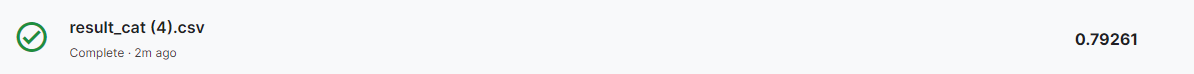

# Общий вывод

Итак, мы создали, настроили, обучили и проанализировали 5 моделей машинного обучения: Логистическая регрессия, KNN, Random Forest, XGBoost, CatBoost. В ходе исследования и сравнения полученных результатов, мы сделали вывод о следующем порядке качества, с которым модели отработали на данной задаче, от лучшего к худшему:
1. XGBoost 0.79822
2. CatBoost 0.79261
3. RandomForest 0.787234
4. Логистическая регрессия 0.782059
5. KNN 0.769983

Разница между лучшим и худшим результатом составила около 3%